# Loading the data

In [1]:
import pandas as pd
import ast


In [2]:
# First you need to download the data from https://www.kaggle.com/datasets/kakarlaramcharan/tmdb-data-0920
# Unzip it and place it in the `input` directory

In [22]:
# Import data from input/movie_data_tmbd.csv, use engine=python, because the file is too big for the default engine
df = pd.read_csv('input/movie_data_tmbd.csv', sep='|', engine='python')

In [23]:
# Print info about the data
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119938 entries, 0 to 119937
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   adult                  119938 non-null  object 
 1   backdrop_path          67084 non-null   object 
 2   belongs_to_collection  9488 non-null    object 
 3   budget                 119394 non-null  object 
 4   genres                 119394 non-null  object 
 5   homepage               20134 non-null   object 
 6   id                     119394 non-null  float64
 7   imdb_id                114477 non-null  object 
 8   original_language      119394 non-null  object 
 9   original_title         119394 non-null  object 
 10  overview               116539 non-null  object 
 11  popularity             119073 non-null  object 
 12  poster_path            119073 non-null  object 
 13  production_companies   119073 non-null  object 
 14  production_countries   119073 non-nu

In [24]:
# How many titles are there in the dataset?
print(df.shape[0])
# How many titles have no less than 10 votes?
print(df[df['vote_count'] >= 20].shape[0])

119938
29817


In [25]:
# Drop rows with less than 10 votes
df = df[df['vote_count'] >= 20]

In [26]:
print(df['vote_average'].map(lambda x: int(x)).value_counts())

vote_average
6    12136
5     7170
7     6965
4     2226
8      683
3      510
2      103
9       12
1       12
Name: count, dtype: int64


Axes(0.125,0.11;0.775x0.77)


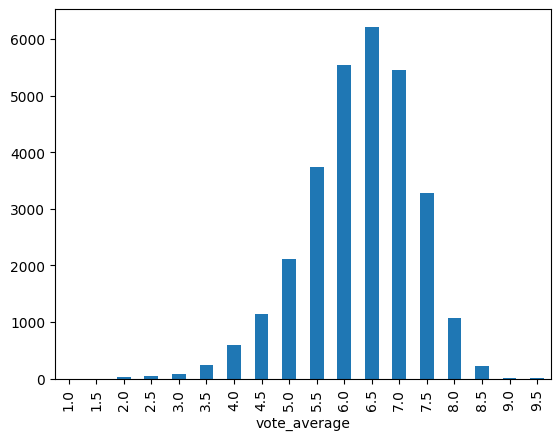

In [27]:
# Map 'vote_average' to nearest 0.5
print(((df['vote_average'] * 2).round() / 2).value_counts().sort_index().plot(kind='bar'))


# Data preprocessing

In [28]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 29817 entries, 1 to 119916
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  29817 non-null  object 
 1   backdrop_path          25473 non-null  object 
 2   belongs_to_collection  4804 non-null   object 
 3   budget                 29817 non-null  object 
 4   genres                 29817 non-null  object 
 5   homepage               7273 non-null   object 
 6   id                     29817 non-null  float64
 7   imdb_id                29790 non-null  object 
 8   original_language      29817 non-null  object 
 9   original_title         29817 non-null  object 
 10  overview               29655 non-null  object 
 11  popularity             29817 non-null  object 
 12  poster_path            29817 non-null  object 
 13  production_companies   29817 non-null  object 
 14  production_countries   29817 non-null  object 
 15  releas

In [29]:
# Find missing values in `tagline`, `overview`
print(df['tagline'].isna().sum())
print(df['overview'].isna().sum())

12843
162


In [30]:
# Fill missing values
df['tagline'] = df['tagline'].fillna('Unknown')
df['overview'] = df['overview'].fillna('Unknown')

In [31]:
# Drop rows with mising release date
df = df.dropna(subset=['release_date'])

# Convert 'release_date' to datetime and extract year, month, day
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['release_day'] = df['release_date'].dt.day

In [32]:
# Handle boolean columns by converting them to integers
# Map `False`/True` to 0/1
df['adult'] = df['adult'].replace({'True': 1, 'False': 0})
df['video'] = df['video'].astype(int)

In [33]:
# Define a helper function to extract names from nested dictionaries in a column
def extract_names(column):
    return column.apply(lambda x: ','.join([d.get('name') for d in ast.literal_eval(x)] if pd.notnull(x) and x != '[]' else []))

# Extract relevant data from nested dictionaries
df['genres'] = extract_names(df['genres'])
df['production_companies'] = extract_names(df['production_companies'])
df['production_countries'] = extract_names(df['production_countries'])
df['cast'] = extract_names(df['cast'])
df['directors'] = extract_names(df['directors'])
df['spoken_languages'] = extract_names(df['spoken_languages'])

In [34]:
# Drop unnecessary columns
df = df.drop(['belongs_to_collection', 'backdrop_path', 'poster_path', 'imdb_id', 'original_title', 'title', 'id', 'homepage', 'release_date'], axis=1)

In [35]:
print(df.head())

   adult  budget         genres original_language  \
1      0       0          Drama                fr   
2      0       0  Drama,Western                en   
3      0       0    Documentary                fr   
4      0  500000  Drama,History                en   
7      0       0        Western                en   

                                            overview popularity  \
1  The tragic story of a young orphan girl who is...      5.482   
2  A fiercely independent cowboy arranges to have...      8.262   
3  Documents the lives of infamous fakers Elmyr d...       7.83   
4  The film follows one day in the lives of the T...      5.694   
7  Character study of a Doctor who saves a local ...      7.869   

                    production_companies      production_countries revenue  \
1  Fidès,Les Films Trocadero,Orsay Films            Austria,France       0   
2                       Joel Productions  United States of America       0   
3                       SACI,Janus Films    

Axes(0.125,0.11;0.775x0.77)


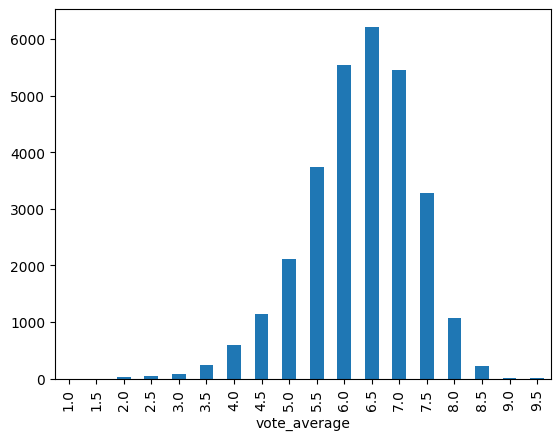

In [36]:
# Map 'vote_average' to nearest 0.5
df['vote_average'] = ((df['vote_average'] * 2).round() / 2)
print(df['vote_average'].value_counts().sort_index().plot(kind='bar'))

In [37]:
#Group vote_average into categories:
# 0.0-5.0 -> bad
# 5.5-6.0 -> mediocre
# 6.5-7.0 -> good
# 7.5-9.9 -> great

# Define the bins and labels
bins = [0.0, 5.0, 6.0, 7.0, 9.9]
labels = ['bad', 'mediocre', 'good', 'great']

# Group vote_average into categories
df['category'] = pd.cut(df['vote_average'], bins=bins, labels=labels, right=True)

# Display the DataFrame
print(df['category'].value_counts())

category
good        11667
mediocre     9273
great        4598
bad          4278
Name: count, dtype: int64


In [38]:
# Take the same number of samples from each category
n = df['category'].value_counts().min()
df = df.groupby('category').apply(lambda x: x.sample(n=n)).reset_index(drop=True)

# Display the DataFrame
print(df['category'].value_counts())

category
bad         4278
mediocre    4278
good        4278
great       4278
Name: count, dtype: int64


/var/folders/ft/_sldpfqn58ggpktbrsrt5gmm0000gn/T/ipykernel_98423/184831406.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby('category').apply(lambda x: x.sample(n=n)).reset_index(drop=True)


# Save data to file

In [39]:
# Save the cleaned data to input/movie_data_tmbd_cleaned.csv
df.to_csv('input/movie_data_tmbd_cleaned.csv', sep='|', index=False)